# Import Libraries

In [1]:
import sqlite3 as sql
import pandas as pd
import datetime
import csv
import numpy as np
import haversine as hs
import os

In [2]:
def jd2cal(jd_val):
    # print(jd_val)
    mjd_val = int(jd_val-2400000.5)
    #print(mjd_val)
    start_time = datetime.date(1858, 11, 17)
    end_date = start_time + datetime.timedelta(days=mjd_val)
    return end_date.strftime("%m/%d/%Y")

In [3]:
def get_dur(row):
    start_date_str = jd2cal(row.iloc[0]["DISCOVERY_DATE"])
    start_date_str = start_date_str + ' '
    start_date_str = start_date_str + str(row.iloc[0]["DISCOVERY_TIME"])
    start_date = datetime.datetime.strptime(start_date_str, '%m/%d/%Y %H%M')

    end_date_str = jd2cal(row.iloc[0]["CONT_DATE"])
    end_date_str = end_date_str + ' '
    end_date_str = end_date_str + str(row.iloc[0]["CONT_TIME"])
    end_date = datetime.datetime.strptime(end_date_str, '%m/%d/%Y %H%M')
    diff = (end_date-start_date).total_seconds() / 3600.0
    return diff 

### Import Database as Dataframe

In [4]:
conn = sql.connect('Data.sqlite')
fire = pd.read_sql('SELECT * FROM Fires', conn)
fire.head(10)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
5,6,6,FS-1418849,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.635278,-120.103611,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00\xf0<~\x90\xa1\x06^\...
6,7,7,FS-1418851,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.688333,-120.153333,5.0,USFS,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00$o\x996\xd0\t^\xc0h\...
7,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,B,40.968056,-122.433889,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4\x9b^\...
8,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,B,41.233611,-122.283333,13.0,STATE OR PRIVATE,CA,None,None,None,"b'\x00\x01\xad\x10\x00\x00\xdc\x8d\x1e""""\x92^\..."
9,10,10,FS-1418859,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.548333,-120.149167,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00dS\\\xf2\x8b\t^\xc0\...


In [5]:
fire.dropna(subset=["DISCOVERY_DATE", "DISCOVERY_TIME","CONT_DATE","CONT_TIME"],inplace=True)

### Create csv with location categories

In [6]:
fire.head()
df = pd.DataFrame()

print(min(fire["LATITUDE"]))
print(max(fire["LATITUDE"]))
print(min(fire["LONGITUDE"]))
print(max(fire["LONGITUDE"]))

bottomLeft = (min(fire["LATITUDE"]), min(fire["LONGITUDE"]))
bottomRight = (min(fire["LATITUDE"]), max(fire["LONGITUDE"]))
topLeft = (max(fire["LATITUDE"]), min(fire["LONGITUDE"]))
topRight = (max(fire["LATITUDE"]), max(fire["LONGITUDE"]))

length = hs.haversine(bottomLeft,bottomRight)
width = hs.haversine(bottomLeft,topLeft)
print(length)
print(width)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=600)
rows = np.linspace(bottomLeft[0], topLeft[0], num=300)
#cols = [round(num,8) for num in cols]
#rows = [round(num,8) for num in rows]

df_cols = np.searchsorted(cols, fire["LONGITUDE"])
df_row = np.searchsorted(rows, fire["LATITUDE"])

col = [str('%.4f'%round(int,4)) for int in cols[df_cols]]
row = [str('%.4f'%round(int,4)) for int in rows[df_row]]

temp = []
for index,val in enumerate(col):
    temp.append(col[index]+','+row[index])

df["LONGITUDE"] = fire["LONGITUDE"]
df["LATITUDE"] = fire["LATITUDE"]
df["LONG/LAT"] = temp
df["DISCOVERY_DATE"] = fire["DISCOVERY_DATE"]
df["DISCOVERY_TIME"] = fire["DISCOVERY_TIME"]
df["CONT_DATE"] = fire["CONT_DATE"]
df["CONT_TIME"] = fire["CONT_TIME"]
df["FIRE_SIZE"] = fire["FIRE_SIZE"]

df.to_csv('Data_with_category.csv')

17.93972222
70.3306
-168.87
-65.25694444
10762.116332162086
5825.607858252318


### Create csv to use in data scraping

In [7]:
LL_list = df["LONG/LAT"].unique()
LL_list = LL_list.tolist()
print(len(LL_list))

23798


In [8]:
Dataset_list = []
Data_csv_list = []
gk = df.groupby("LONG/LAT")

for LL in LL_list:
    temp_list = [None]*4
    LL_df = gk.get_group(LL)
    LL_df = LL_df.sort_values(by=["DISCOVERY_DATE"],ascending=False)
    LL_df = LL_df.head(1)
    Dataset_list.append(LL_df)
    temp_list[0] = LL.split(',')[0]
    temp_list[1] = LL.split(',')[1]
    temp_list[2] = jd2cal(LL_df['DISCOVERY_DATE']+83)
    temp_list[3] = jd2cal(LL_df['CONT_DATE']+90)
    Data_csv_list.append(temp_list)

with open('Data_to_Scrape.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for val in Data_csv_list:
        spamwriter.writerow([val[0], val[1], val[2], val[3]])

In [9]:
files = os.listdir('Fire_Files')
Fire_Files = {}

for file_name in files:
    file = file_name.split('_')
    location = str('%.4f'%float('-'+file[6].replace('d','.').replace('W','')))+','+str('%.4f'%float(file[5].replace('d','.').replace('N','')))
    Fire_Files[location] = file_name

files = os.listdir('No_Fire_Files')
No_Fire_Files = {}

for file_name in files:
    file = file_name.split('_')
    location = str('%.4f'%float('-'+file[6].replace('d','.').replace('W','')))+','+str('%.4f'%float(file[5].replace('d','.').replace('N','')))
    No_Fire_Files[location] = file_name

In [10]:
index = 0

print(len(Dataset_list))

with open('Data_Final_All.csv', 'w') as csv_file:  
    header = Dataset_list[0].columns.values.tolist()
    header.append("DUR")
    header.append("DISCOVERY_DATE_J")
    header.remove("LONG/LAT")
    header.remove("DISCOVERY_TIME")
    header.remove("CONT_DATE")
    header.remove("CONT_TIME")
    for ind1 in range(0,7):
        header.append("T2M_"+str(ind1))
        header.append("T2MDEW_"+str(ind1))
        header.append("T2MWET_"+str(ind1))
        header.append("TS_"+str(ind1))
        header.append("T2M_RANGE_"+str(ind1))
        header.append("T2M_MAX_"+str(ind1))
        header.append("T2M_MIN_"+str(ind1))
        header.append("QV2M_"+str(ind1))
        header.append("RH2M_"+str(ind1))
        header.append("PRECTOTCORR_"+str(ind1))
        header.append("PS_"+str(ind1))
        header.append("WS10M_"+str(ind1))
        header.append("WS10M_MAX_"+str(ind1))
        header.append("WS10M_MIN_"+str(ind1))
        header.append("WS10M_RANGE_"+str(ind1))
        header.append("WS50M_"+str(ind1))
        header.append("WS50M_MAX_"+str(ind1))
        header.append("WS50M_MIN_"+str(ind1))
        # T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN

    writer = csv.DictWriter(csv_file, fieldnames = header)
    writer.writeheader()
    for index, row in enumerate(Dataset_list):
        Data_temp = {}
        Data_temp["LONGITUDE"] = row.iloc[0]["LONGITUDE"]
        Data_temp["LATITUDE"] = row.iloc[0]["LATITUDE"]
        Data_temp["DISCOVERY_DATE"] = jd2cal(row.iloc[0]["DISCOVERY_DATE"])
        Data_temp["DISCOVERY_DATE_J"] = row.iloc[0]["DISCOVERY_DATE"]
        #Data_temp["DUR"] = get_dur(row)
        Data_temp["FIRE_SIZE"] = row.iloc[0]["FIRE_SIZE"]

        with open('Fire_Files/'+Fire_Files[row.iloc[0]["LONG/LAT"]], newline='') as csvfile1:
            spamreader = csv.reader(csvfile1, delimiter=',', quotechar='|')
            for i in range(0,28):
                next(spamreader)
            for ind2,line in enumerate(spamreader):
                if(ind2>6):
                    break
                Data_temp["T2M_"+str(ind2)] = line[3]
                Data_temp["T2MDEW_"+str(ind2)] = line[4]
                Data_temp["T2MWET_"+str(ind2)] = line[5]
                Data_temp["TS_"+str(ind2)] = line[6]
                Data_temp["T2M_RANGE_"+str(ind2)] = line[7]
                Data_temp["T2M_MAX_"+str(ind2)] = line[8]
                Data_temp["T2M_MIN_"+str(ind2)] = line[9]
                Data_temp["QV2M_"+str(ind2)] = line[10]
                Data_temp["RH2M_"+str(ind2)] = line[11]
                Data_temp["PRECTOTCORR_"+str(ind2)] = line[12]
                Data_temp["PS_"+str(ind2)] = line[13]
                Data_temp["WS10M_"+str(ind2)] = line[14]
                Data_temp["WS10M_MAX_"+str(ind2)] = line[15]
                Data_temp["WS10M_MIN_"+str(ind2)] = line[16]
                Data_temp["WS10M_RANGE_"+str(ind2)] = line[17]
                Data_temp["WS50M_"+str(ind2)] = line[18]
                Data_temp["WS50M_MAX_"+str(ind2)] = line[19]
                Data_temp["WS50M_MIN_"+str(ind2)] = line[20]

        writer.writerow(Data_temp)

        #Data_temp["DUR"] = 0
        Data_temp["FIRE_SIZE"] = 0
        Data_temp["DISCOVERY_DATE"] = jd2cal(row.iloc[0]['CONT_DATE']+90)
        with open('No_Fire_Files/'+No_Fire_Files[row.iloc[0]["LONG/LAT"]], newline='') as csvfile2:
            spamreader = csv.reader(csvfile2, delimiter=',', quotechar='|')
            for i in range(0,28):
                next(spamreader)
            for ind3,line in enumerate(spamreader):
                if(ind3>6):
                    break
                Data_temp["T2M_"+str(ind3)] = line[3]
                Data_temp["T2MDEW_"+str(ind3)] = line[4]
                Data_temp["T2MWET_"+str(ind3)] = line[5]
                Data_temp["TS_"+str(ind3)] = line[6]
                Data_temp["T2M_RANGE_"+str(ind3)] = line[7]
                Data_temp["T2M_MAX_"+str(ind3)] = line[8]
                Data_temp["T2M_MIN_"+str(ind3)] = line[9]
                Data_temp["QV2M_"+str(ind3)] = line[10]
                Data_temp["RH2M_"+str(ind3)] = line[11]
                Data_temp["PRECTOTCORR_"+str(ind3)] = line[12]
                Data_temp["PS_"+str(ind3)] = line[13]
                Data_temp["WS10M_"+str(ind3)] = line[14]
                Data_temp["WS10M_MAX_"+str(ind3)] = line[15]
                Data_temp["WS10M_MIN_"+str(ind3)] = line[16]
                Data_temp["WS10M_RANGE_"+str(ind3)] = line[17]
                Data_temp["WS50M_"+str(ind3)] = line[18]
                Data_temp["WS50M_MAX_"+str(ind3)] = line[19]
                Data_temp["WS50M_MIN_"+str(ind3)] = line[20]

        writer.writerow(Data_temp)

        if(index%1000==0):
            print(index)

23798
0
1000
2000
3000


In [ ]:
Data_final_csv = pd.read_csv('Data_final_All.csv')
Data_final_csv.head(10)

,LONGITUDE,LATITUDE,DISCOVERY_DATE,FIRE_SIZE,DUR,DISCOVERY_DATE_J,T2M_0,T2MDEW_0,T2MWET_0,TS_0,...,RH2M_6,PRECTOTCORR_6,PS_6,WS10M_6,WS10M_MAX_6,WS10M_MIN_6,WS10M_RANGE_6,WS50M_6,WS50M_MAX_6,WS50M_MIN_6
0,-120.966667,40.144722,12/07/2015,0.1,0.500000,2457363.5,1.58,-3.03,-0.72,0.77,...,94.81,1.12,87.17,2.12,3.19,1.54,1.65,4.15,5.34,3.21
1,-120.966667,40.144722,03/06/2016,0.0,0.000000,2457363.5,6.94,-0.03,3.46,4.23,...,94.00,27.23,85.64,3.88,4.84,2.30,2.54,6.80,8.51,3.96
2,-120.355278,38.868611,08/07/2014,0.1,3.000000,2456876.5,22.87,1.39,12.13,22.23,...,48.94,0.12,81.16,1.84,3.06,1.27,1.80,2.58,4.10,1.46
3,-120.355278,38.868611,11/05/2014,0.0,0.000000,2456876.5,9.26,-3.20,3.02,7.68,...,61.25,0.00,81.59,2.52,3.38,1.47,1.91,3.71,4.65,2.31
4,-120.759600,39.024200,10/18/2015,0.1,4.600000,2457313.5,20.80,3.71,12.25,18.40,...,82.00,0.84,87.50,1.65,3.28,0.77,2.52,2.66,4.55,1.63
5,-120.759600,39.024200,01/16/2016,0.0,0.000000,2457313.5,1.58,-0.25,0.66,0.87,...,98.25,10.65,87.93,2.13,2.86,1.30,1.55,4.25,5.96,2.81
6,-119.745833,38.595000,08/01/2015,0.1,5.750000,2457235.5,16.12,-2.01,7.05,14.89,...,45.88,1.01,80.87,1.62,3.05,0.34,2.71,2.85,4.23,0.54
7,-119.745833,38.595000,10/30/2015,0.0,0.000000,2457235.5,9.66,-2.76,3.45,7.82,...,43.56,0.00,80.73,2.43,3.71,1.14,2.57,4.15,5.75,1.59
8,-120.088611,38.485000,09/20/2015,0.5,9.716667,2457285.5,13.36,5.70,9.53,13.40,...,20.94,0.00,80.77,2.34,3.68,0.88,2.80,3.55,5.01,1.80
9,-120.088611,38.485000,12/19/2015,0.0,0.000000,2457285.5,-2.83,-3.29,-3.06,-2.91,...,97.31,8.20,79.88,2.56,4.09,0.95,3.14,4.24,6.37,1.16


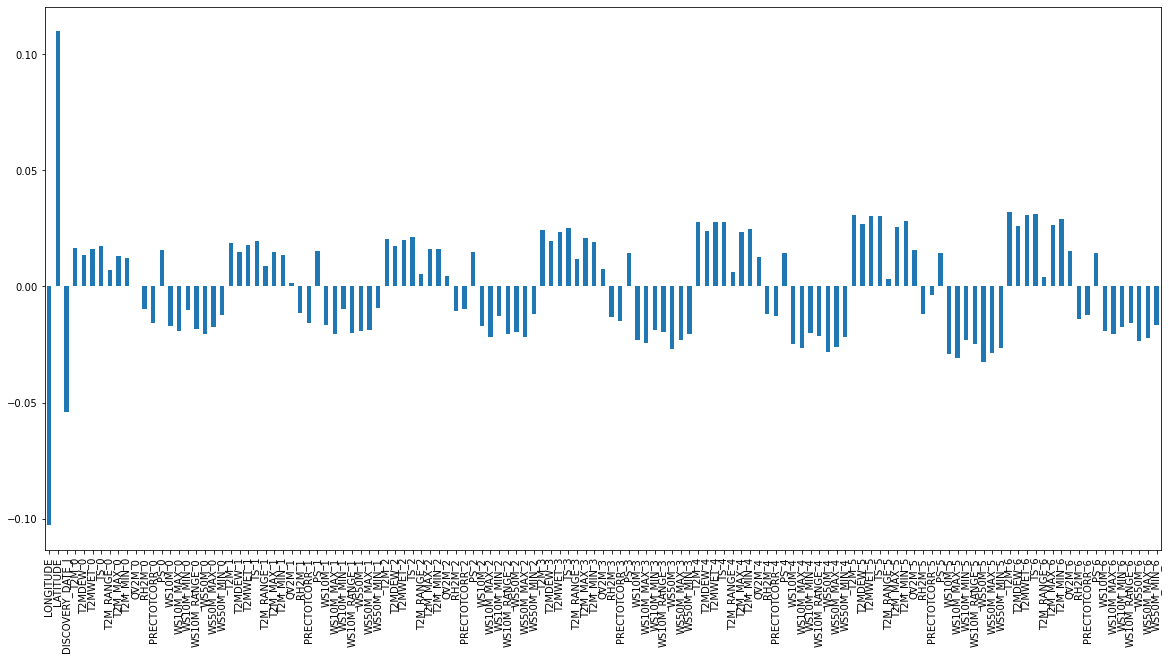

In [ ]:
corrM = Data_final_csv.corr()
corrM.drop(['FIRE_SIZE'],inplace=True,axis=1)
Plot_data = corrM.iloc[2]
Plot_data
ax = Plot_data.plot.bar(x='lab', y='val', rot=90,figsize=(20,10))

In [ ]:
Col_to_drop = []
for index,val in Plot_data.items():
    if(abs(val) < 0.008):
        Col_to_drop.append(index)
print(Col_to_drop)

['T2M_RANGE_0', 'QV2M_0', 'QV2M_1', 'T2M_RANGE_2', 'QV2M_2', 'QV2M_3', 'T2M_RANGE_4', 'T2M_RANGE_5', 'PRECTOTCORR_5', 'T2M_RANGE_6']


In [ ]:
Data_final_csv.drop(Col_to_drop,inplace=True,axis=1)
Data_final_csv.head(10)

,LONGITUDE,LATITUDE,DISCOVERY_DATE,FIRE_SIZE,DUR,DISCOVERY_DATE_J,T2M_0,T2MDEW_0,T2MWET_0,TS_0,...,RH2M_6,PRECTOTCORR_6,PS_6,WS10M_6,WS10M_MAX_6,WS10M_MIN_6,WS10M_RANGE_6,WS50M_6,WS50M_MAX_6,WS50M_MIN_6
0,-120.966667,40.144722,12/07/2015,0.1,0.500000,2457363.5,1.58,-3.03,-0.72,0.77,...,94.81,1.12,87.17,2.12,3.19,1.54,1.65,4.15,5.34,3.21
1,-120.966667,40.144722,03/06/2016,0.0,0.000000,2457363.5,6.94,-0.03,3.46,4.23,...,94.00,27.23,85.64,3.88,4.84,2.30,2.54,6.80,8.51,3.96
2,-120.355278,38.868611,08/07/2014,0.1,3.000000,2456876.5,22.87,1.39,12.13,22.23,...,48.94,0.12,81.16,1.84,3.06,1.27,1.80,2.58,4.10,1.46
3,-120.355278,38.868611,11/05/2014,0.0,0.000000,2456876.5,9.26,-3.20,3.02,7.68,...,61.25,0.00,81.59,2.52,3.38,1.47,1.91,3.71,4.65,2.31
4,-120.759600,39.024200,10/18/2015,0.1,4.600000,2457313.5,20.80,3.71,12.25,18.40,...,82.00,0.84,87.50,1.65,3.28,0.77,2.52,2.66,4.55,1.63
5,-120.759600,39.024200,01/16/2016,0.0,0.000000,2457313.5,1.58,-0.25,0.66,0.87,...,98.25,10.65,87.93,2.13,2.86,1.30,1.55,4.25,5.96,2.81
6,-119.745833,38.595000,08/01/2015,0.1,5.750000,2457235.5,16.12,-2.01,7.05,14.89,...,45.88,1.01,80.87,1.62,3.05,0.34,2.71,2.85,4.23,0.54
7,-119.745833,38.595000,10/30/2015,0.0,0.000000,2457235.5,9.66,-2.76,3.45,7.82,...,43.56,0.00,80.73,2.43,3.71,1.14,2.57,4.15,5.75,1.59
8,-120.088611,38.485000,09/20/2015,0.5,9.716667,2457285.5,13.36,5.70,9.53,13.40,...,20.94,0.00,80.77,2.34,3.68,0.88,2.80,3.55,5.01,1.80
9,-120.088611,38.485000,12/19/2015,0.0,0.000000,2457285.5,-2.83,-3.29,-3.06,-2.91,...,97.31,8.20,79.88,2.56,4.09,0.95,3.14,4.24,6.37,1.16


In [ ]:
Data_final_csv.to_csv('Data_final_Dropped.csv',index=False)